<a href="https://colab.research.google.com/github/Oreolorun/NeuralNetsPractice/blob/main/EndToEndPractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#  mounting drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#  unzipping dataset
!unzip gdrive/My\ Drive/Datasets/kagglecatsanddogs_3367a.zip > /dev/null

In [4]:
import numpy as np
from tqdm import tqdm, tqdm_notebook
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import cv2
import os
import time
import pandas as pd
import seaborn as sns

In [6]:
torch.cuda.is_available()

True

In [7]:
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

In [11]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the GPU


In [12]:
#  Initiate flag
rebuild_dataset = True

class DogsVSCats():
  def __init__(self):
    self.cats = 'PetImages/Cat'
    self.dogs = 'PetImages/Dog'
    self.labels = {self.cats:0, self.dogs:1}
    self.img_size = 50
    self.training_data = []
    self.cat_count = 0
    self.dog_count = 0

  def make_dataset(self):
    #  original images
    for label in self.labels:
      print(label)
      for file in tqdm(os.listdir(label)):
        try:
          path = os.path.join(label, file)
          image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
          image = cv2.resize(image, (self.img_size, self.img_size))
          image = np.array(image)
          self.training_data.append([image, np.eye(2)[self.labels[label]]])
          if label == self.cats:
            self.cat_count+=1
          elif label == self.dogs:
            self.dog_count+=1
        except Exception as e:
          pass
    print('Flipping images...')
    for label in self.labels:
      print(label)
      #  flipped images
      for file in tqdm(os.listdir(label)):
        try:
          path = os.path.join(label, file)
          image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
          image = cv2.resize(image, (self.img_size, self.img_size))
          image = cv2.flip(image, 1)
          image = cv2.blur(image, (2,2))
          image = np.array(image)
          self.training_data.append([image, np.eye(2)[self.labels[label]]])
          if label == self.cats:
            self.cat_count+=1
          elif label == self.dogs:
            self.dog_count+=1
        except Exception as e:
          pass
    np.random.shuffle(self.training_data)
    np.save('training_data.npy', self.training_data)
    print(f'\nCat Images: {self.cat_count}')
    print(f'Dog Images: {self.dog_count}')
    print(f'Total Number of Images: {self.cat_count+self.dog_count}')

if rebuild_dataset:
  dataset = DogsVSCats()
  dataset.make_dataset()
  dataset = np.load('training_data.npy', allow_pickle=True)
  print("Done!\nDataset data can now be found in object 'dataset'.\nRemember to reset flag to False.")
  #  Flag manually changed to False

PetImages/Cat


100%|██████████| 12501/12501 [00:15<00:00, 806.02it/s]


PetImages/Dog


100%|██████████| 12501/12501 [00:16<00:00, 756.57it/s]


Flipping images...
PetImages/Cat


100%|██████████| 12501/12501 [00:15<00:00, 809.08it/s]


PetImages/Dog


100%|██████████| 12501/12501 [00:16<00:00, 755.74it/s]
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)



Cat Images: 24952
Dog Images: 24940
Total Number of Images: 49892
Done!
Dataset data can now be found in object 'dataset'.
Remember to reset flag to False.


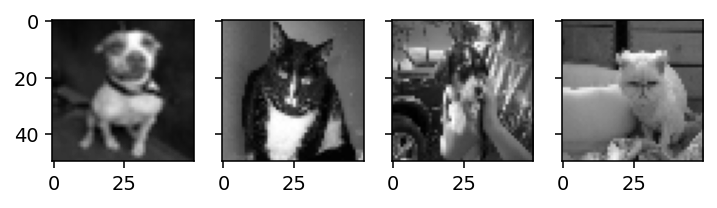

In [13]:
#  Displaying random images
figure, axes = plt.subplots(1,4, dpi=140, sharey=True)
axes[0].imshow(dataset[0][0], cmap='gray')
axes[1].imshow(dataset[4756][0], cmap='gray')
axes[2].imshow(dataset[10845][0], cmap='gray')
axes[3].imshow(dataset[23975][0], cmap='gray')

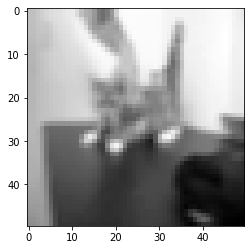

In [14]:
test_img = cv2.imread('PetImages/Cat/0.jpg', cv2.IMREAD_GRAYSCALE)
test_img = cv2.resize(test_img, (50,50))
test_img = cv2.blur(test_img, (2,2))
plt.imshow(test_img, cmap='gray')

In [15]:
#  Defining function to split data
def split_data(data, split_pct):
  num_instances = len(data)
  split_size = int(num_instances*split_pct)
  idx = np.random.permutation(num_instances)
  return idx[:split_size], idx[split_size:]

#  Splitting into training, validation and test set
test_indices, data_indices = split_data(dataset, 0.1)
val_indices, train_indices = split_data(data_indices, 0.2)

In [16]:
training_data = dataset[train_indices]
validation_data = dataset[val_indices]
testing_data = dataset[test_indices]

In [17]:
training_data[0]

array([array([[166, 166, 170, ..., 125, 123, 122],
       [166, 166, 170, ..., 125, 123, 122],
       [174, 174, 175, ..., 129, 127, 126],
       ...,
       [140, 140, 114, ..., 110, 113,  97],
       [ 99,  99, 103, ...,  90, 113, 103],
       [ 92,  92, 108, ...,  54,  84,  99]], dtype=uint8),
       array([0., 1.])], dtype=object)

In [18]:
from torch.utils.data import DataLoader, SubsetRandomSampler, TensorDataset

#  Creating samplers
test_sampler = SubsetRandomSampler(test_indices)
val_sampler = SubsetRandomSampler(val_indices)
train_sampler = SubsetRandomSampler(train_indices)

#  Creating training, validation and testing dataloaders.
batch_size = 100
test_dl = DataLoader(dataset, sampler=test_sampler, batch_size=batch_size)
val_dl = DataLoader(dataset, sampler=val_sampler, batch_size=batch_size)
train_dl = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size)

In [36]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,32,5)
    self.conv2 = nn.Conv2d(32,64,5)
    self.conv3 = nn.Conv2d(64,128,5)
    self.fc1 = nn.Linear(128*2*2,512)
    self.fc2 = nn.Linear(512,2)
    self.pool = nn.MaxPool2d(2,2)

  def forward(self, x):
    x = x.view(-1,1,50,50)
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    output = F.softmax(x, dim=1)
    return output

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [20]:
#  Spliting training data 
X_train = torch.Tensor([x[0] for x in training_data])
y_train = torch.Tensor([x[1] for x in training_data])

#  Spliting validation data
X_val = torch.Tensor([x[0] for x in validation_data])
y_val = torch.Tensor([x[1] for x in validation_data])

#  Spliting testing data
X_test = torch.Tensor([x[0] for x in testing_data])
y_test = torch.Tensor([x[1] for x in testing_data])

#  Scaling all pixels
X_train = X_train/225
X_val = X_val/225
X_test = X_test/225

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


In [21]:
len(X_train)

35923

In [22]:
import torch.optim as optim

In [37]:
#  Training
loss_fn = nn.MSELoss()
optimiser = optim.Adam(net.parameters(), lr=0.001)

batch_size = 512
epochs = 13
metrics = []

#  deriving accuracy
def get_accuracy(data_x, data_y, batch):
  accu_count = 0  
  with torch.no_grad():
    for l in tqdm(range(0, len(data_x), batch)):
      test_batch_x = data_x[l:l+batch]
      test_batch_y = data_y[l:l+batch]
      outputs_val = net(test_batch_x)
      for k in range(len(test_batch_x)):
        idx_val_out = torch.argmax(outputs_val[k])
        idx_truth_val = torch.argmax(test_batch_y[k])
        if idx_val_out == idx_truth_val:
          accu_count+=1
    val_acc = accu_count/len(data_x)
    outputs_all = net(data_x)
    val_loss = loss_fn(outputs_all, data_y)
  return val_acc, val_loss


#  Looping through batches for each epoch
for epoch in range(epochs):
  #  initialising a counter for accuracy
  accuracy_count = 0
  for i in tqdm_notebook(range(0, len(X_train), batch_size)):
    # creating a batch of pixels
    batch_x = X_train[i:i+batch_size]
    #  creating a batch of labels
    batch_y = y_train[i:i+batch_size]
    #  moving to gpu
    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
    #  setting gradients to zero
    net.zero_grad()
    #  predicting
    outputs = net(batch_x)
    #  calculating loss
    loss = loss_fn(outputs.float(), batch_y.float())
    #  looping through images in the validation set
    for j in range(len(outputs)):
      #  determining the class of prediction
      idx_pred = torch.argmax(outputs[j])
      #  determining the class of label
      idx_truth = torch.argmax(batch_y[j])
      #  comparing prediction to ground truth
      if idx_pred == idx_truth:
        accuracy_count+=1
    #  calculating gradients
    loss.backward()
    #  adjusting weights
    optimiser.step()
  X_val, y_val = X_val.to(device), y_val.to(device)
  val_accuracy, val_loss = get_accuracy(X_val, y_val, batch_size)
  in_sample_accuracy = accuracy_count/len(X_train)
  metrics.append([epoch+1, loss, in_sample_accuracy, val_loss, val_accuracy])
  print(f'Epoch: {epoch+1}/{epochs}  Insample_Loss: {round(loss.item(), 2)}  Insample_Accuracy: {round(accuracy_count/len(X_train), 2)}  Validation_Loss: {round(val_loss.item(), 2)}  Validation_Accuracy: {round(val_accuracy, 2)}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/71 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:01<00:00, 13.53it/s]


Epoch: 1/13  Insample_Loss: 0.21  Insample_Accuracy: 0.57  Validation_Loss: 0.24  Validation_Accuracy: 0.6


  0%|          | 0/71 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:01<00:00, 14.05it/s]


Epoch: 2/13  Insample_Loss: 0.19  Insample_Accuracy: 0.64  Validation_Loss: 0.22  Validation_Accuracy: 0.64


  0%|          | 0/71 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:01<00:00, 13.96it/s]


Epoch: 3/13  Insample_Loss: 0.17  Insample_Accuracy: 0.68  Validation_Loss: 0.21  Validation_Accuracy: 0.67


  0%|          | 0/71 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:01<00:00, 13.87it/s]


Epoch: 4/13  Insample_Loss: 0.14  Insample_Accuracy: 0.71  Validation_Loss: 0.2  Validation_Accuracy: 0.7


  0%|          | 0/71 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:01<00:00, 13.84it/s]


Epoch: 5/13  Insample_Loss: 0.11  Insample_Accuracy: 0.74  Validation_Loss: 0.18  Validation_Accuracy: 0.74


  0%|          | 0/71 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:01<00:00, 13.70it/s]


Epoch: 6/13  Insample_Loss: 0.1  Insample_Accuracy: 0.76  Validation_Loss: 0.17  Validation_Accuracy: 0.74


  0%|          | 0/71 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:01<00:00, 14.06it/s]


Epoch: 7/13  Insample_Loss: 0.08  Insample_Accuracy: 0.77  Validation_Loss: 0.17  Validation_Accuracy: 0.75


  0%|          | 0/71 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:01<00:00, 13.85it/s]


Epoch: 8/13  Insample_Loss: 0.06  Insample_Accuracy: 0.79  Validation_Loss: 0.17  Validation_Accuracy: 0.76


  0%|          | 0/71 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:01<00:00, 13.85it/s]


Epoch: 9/13  Insample_Loss: 0.06  Insample_Accuracy: 0.8  Validation_Loss: 0.16  Validation_Accuracy: 0.77


  0%|          | 0/71 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:01<00:00, 14.04it/s]


Epoch: 10/13  Insample_Loss: 0.05  Insample_Accuracy: 0.81  Validation_Loss: 0.16  Validation_Accuracy: 0.77


  0%|          | 0/71 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:01<00:00, 13.85it/s]


Epoch: 11/13  Insample_Loss: 0.04  Insample_Accuracy: 0.82  Validation_Loss: 0.17  Validation_Accuracy: 0.76


  0%|          | 0/71 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:01<00:00, 13.92it/s]


Epoch: 12/13  Insample_Loss: 0.05  Insample_Accuracy: 0.82  Validation_Loss: 0.16  Validation_Accuracy: 0.77


  0%|          | 0/71 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:01<00:00, 13.82it/s]


Epoch: 13/13  Insample_Loss: 0.05  Insample_Accuracy: 0.83  Validation_Loss: 0.16  Validation_Accuracy: 0.77


In [33]:
ep = [x[0] for x in metrics]
train_acc = [x[2] for x in metrics]
train_loss = [x[1].item() for x in metrics]
val_acc = [x[4] for x in metrics]
val_loss = [x[3].item() for x in metrics]

Text(0.5, 1.0, 'Loss')

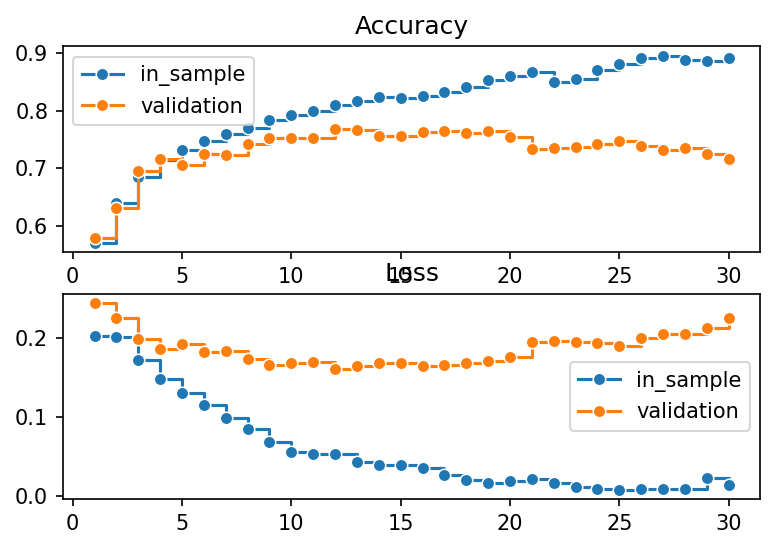

In [34]:
figure, axes = plt.subplots(2,1, dpi=150)
sns.lineplot(x=ep, y=train_acc, label='in_sample', ax=axes[0], marker='o', drawstyle='steps-post')
sns.lineplot(x=ep, y=val_acc, label='validation', ax=axes[0], marker='o', drawstyle='steps-post')
axes[0].set_title('Accuracy')

sns.lineplot(x=ep, y=train_loss, label='in_sample', ax=axes[1], marker='o', drawstyle='steps-post')
sns.lineplot(x=ep, y=val_loss, label='validation', ax=axes[1], marker='o', drawstyle='steps-post')
axes[1].set_title('Loss')

In [39]:
#  deriving accuracy
def get_test_accuracy(data_x, data_y, batch):
  accuracy_count = 0  
  with torch.no_grad():
    for l in range(0, len(data_x), batch):
      test_batch_x = data_x[l:l+batch]
      test_batch_y = data_y[l:l+batch]
      test_batch_x, test_batch_y = test_batch_x.to(device), test_batch_y.to(device)
      outputs_val = net(test_batch_x)
      for k in range(len(test_batch_x)):
        idx_val_out = torch.argmax(outputs_val[k])
        idx_truth_val = torch.argmax(test_batch_y[k])
        if idx_val_out == idx_truth_val:
          accuracy_count+=1
  return print(f'\nAccuracy: {round(accuracy_count/len(data_x), 2)}')

get_test_accuracy(X_test, y_test, 100)


Accuracy: 0.81


In [43]:
len(X_test)

4989

tensor([0.0036, 0.9964], device='cuda:0')
Prediction: Dog


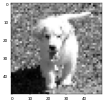

In [58]:
import matplotlib.pyplot as plt
img = 228
with torch.no_grad():
  temp_1 = net(X_test[img].to(device))
  if torch.argmax(temp_1) == 0:
    print(temp_1)
    print('Prediction: Cat')
  else:
    print(temp_1[0])
    print('Prediction: Dog')
  plt.figure(dpi=30)
  plt.imshow(X_test[img], cmap='gray')